Veto on Length @ 70 mm
Veto on Integrated Charge @ 800k


 99%|█████████▉| 100/101 [00:00<00:00, 763.37it/s]


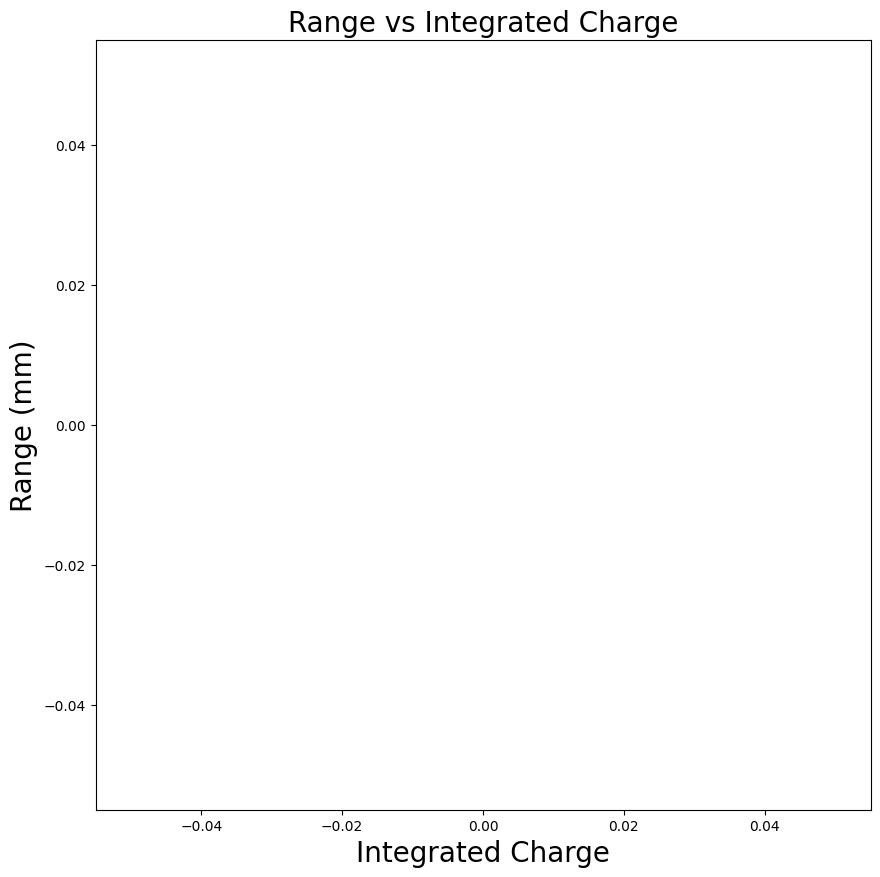

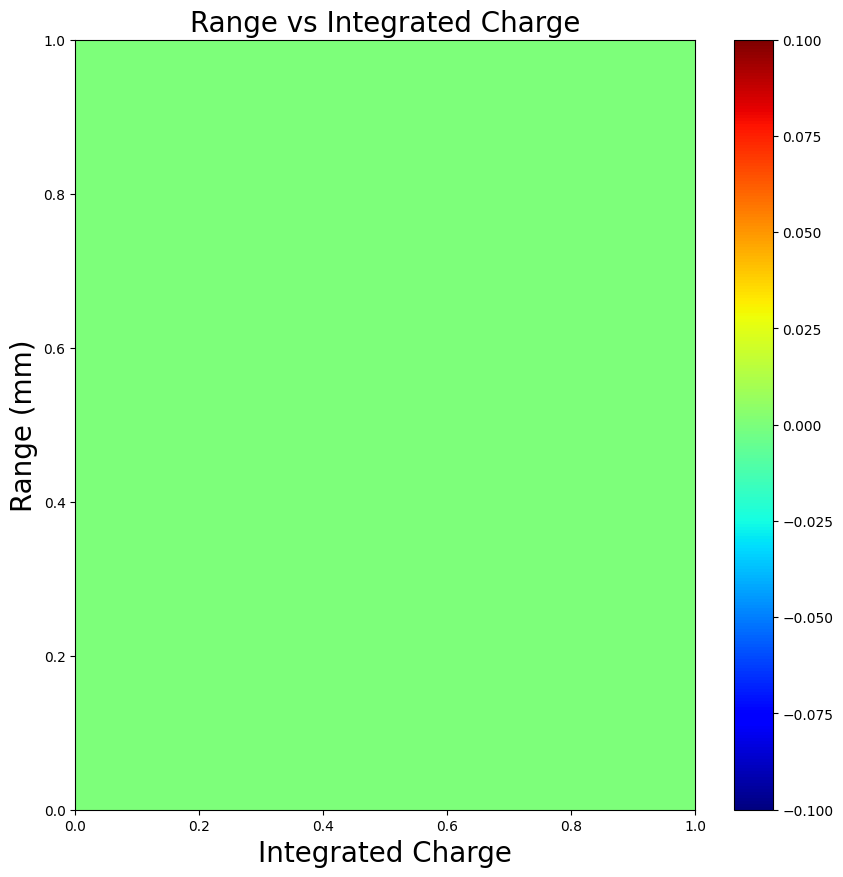

  0%|          | 0/100 [00:00<?, ?it/s]


Index to use for next for batch: 0


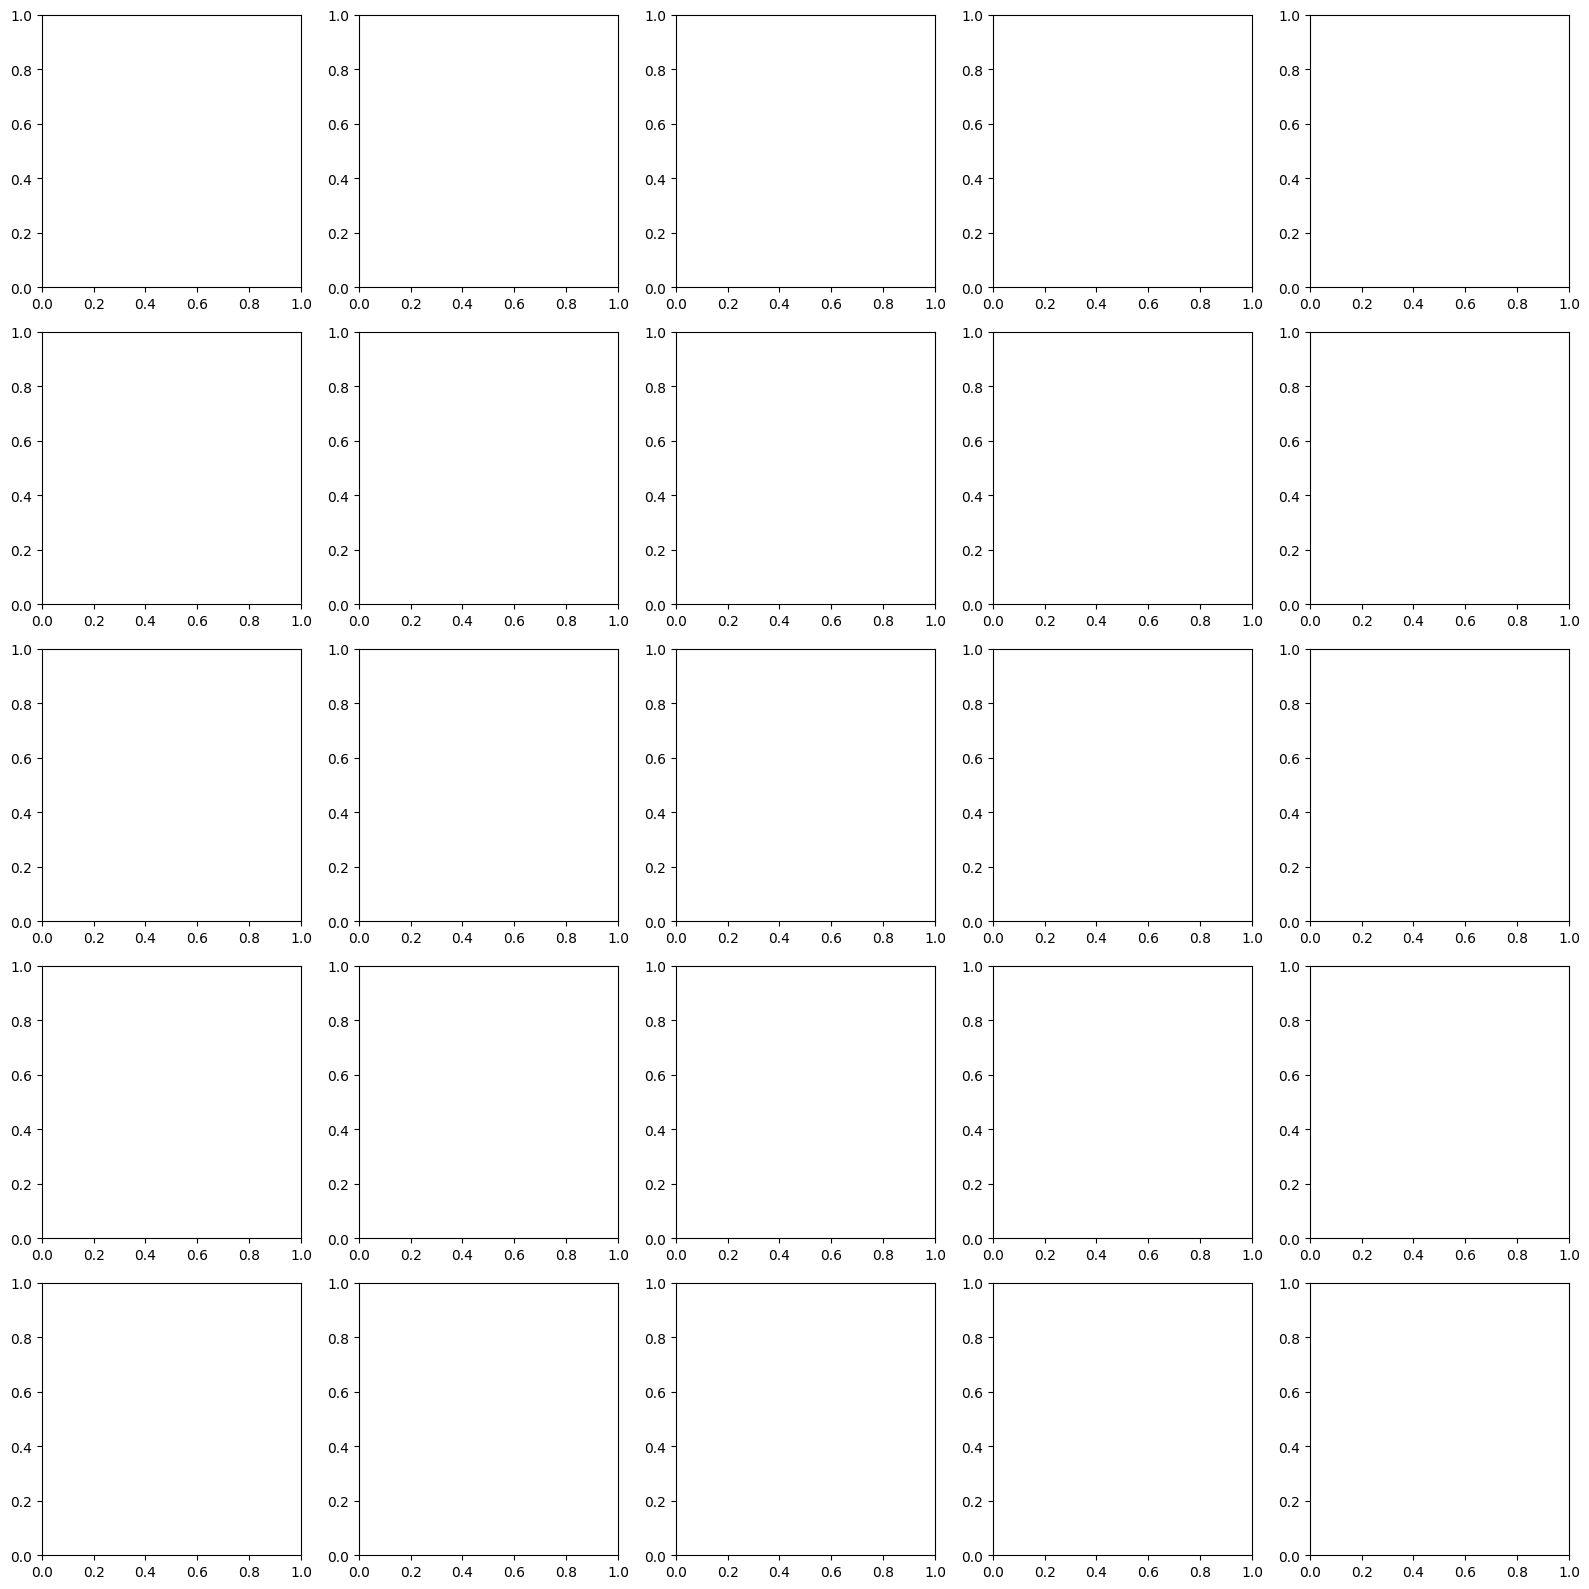

IndexError: list index out of range

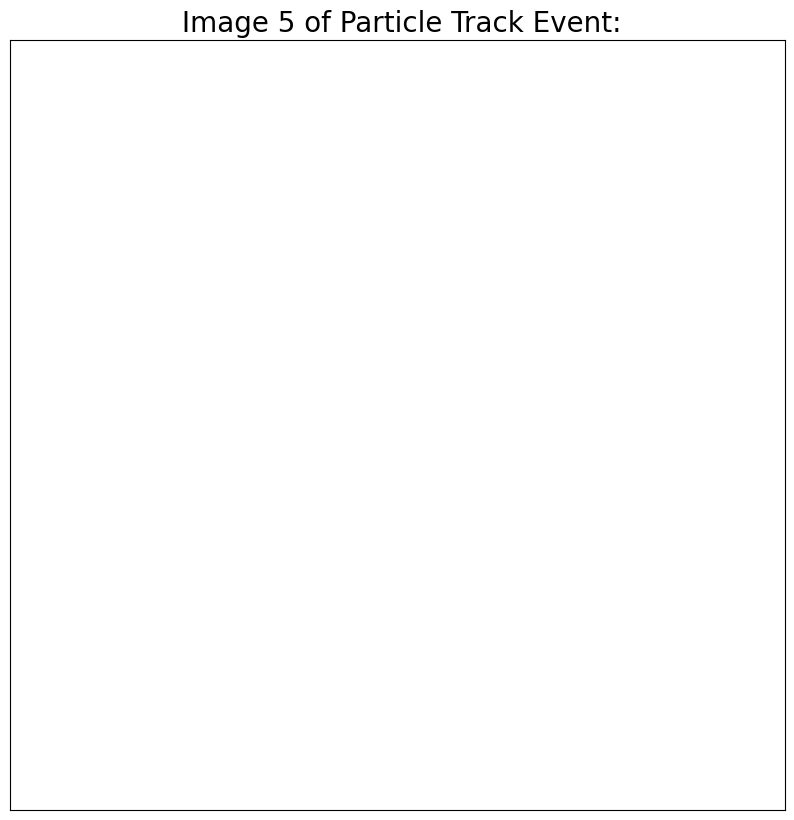

In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[50]:


#!/usr/bin/env python
# coding: utf-8

# # E21072: Range vs Energy Plot
# ### This notebook pre-processes GADGET II tracks and generate a range vs energy density plot
# ###### - Uses PCA to find length of the track
# ###### - Uses Hotelling and SPE as complementary outlier removal algorithms (Optional)

# In[1]:


# Import packages and read in all files

import numpy as np
import h5py
import math
from sklearn.decomposition import PCA
from pca import pca
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import peakutils
import os, sys
from BaselineRemoval import BaselineRemoval
from sklearn.cluster import DBSCAN

# H5 file to read
f = h5py.File('500a.h5', 'r')
h5file = f



# In[2]:
class HiddenPrints:
	def __enter__(self):
		self._original_stdout = sys.stdout
		sys.stdout = open(os.devnull, 'w')

	def __exit__(self, exc_type, exc_val, exc_tb):
		sys.stdout.close()
		sys.stdout = self._original_stdout


def remove_outliers(xset, yset, zset, eset, threshold):
	"""
	Uses DBSCAN to find and remove outliers in 3D data
	"""

	data = np.array([xset.T, yset.T, zset.T]).T
	DBSCAN_cluster = DBSCAN(eps=7, min_samples=10).fit(data)
	out_of_cluster_index = np.where(DBSCAN_cluster.labels_==-1)
	del data
	rev = out_of_cluster_index[0][::-1]
	#if len(out_of_cluster_index[0]) > 0:
	for i in rev:
		xset = np.delete(xset, i)
		yset = np.delete(yset, i)
		zset = np.delete(zset, i)
		eset = np.delete(eset, i)

	if len(xset) <= threshold:
		veto = True
	else:
		veto = False

	return xset, yset, zset, eset, veto
# In[3]:

print('Veto on Length @ 70 mm')
print('Veto on Integrated Charge @ 800k')
def track_len(xset, yset, zset):
    """
    Uses PCA to find the length of a track
    """
    veto_on_length = False
 
    # Form data matrix
    data = np.concatenate((xset[:, np.newaxis], 
                           yset[:, np.newaxis], 
                           zset[:, np.newaxis]), 
                           axis=1)

    # Use PCA to find track length
    pca = PCA(n_components=2)
    principalComponents = pca.fit(data)
    principalComponents = pca.transform(data)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    
    track_len = 2.35*principalDf.std()[0]
    if track_len > 70:
        veto_on_length = True
    
    return track_len, veto_on_length




def main(h5file, threshold):
    """
    This functions does the following: 
    - Converts h5 files into ndarrays. 
    - Removes outliers.
    - Calls PCA to return track length.
    - Sums mesh signal to return energy.
    """
    # Converts h5 files into ndarrays, and output each event dataset as a separte list
    num_events = int(len(list(h5file.keys()))/2) 
    
    len_list = []
    good_events = []
    tot_energy = []
    skipped_events = 0
    veto_events = 0
    
    pbar = tqdm(total=num_events+1)
    for i in range(0, num_events):
        str_event = f"Event_[{i}]"
        
        # Apply pad threshold
        event = np.array(h5file[str_event][:])
        if len(event) <= threshold:
            skipped_events += 1
            pbar.update(n=1)
            continue
            
        # Make copy of datasets
        dset_0_copyx = event['x'] 
        dset_0_copyy = event['y'] 
        dset_0_copyz = event['z'] - min(event['z'])
        dset_0_copye = event['A']

        
        # Apply veto condition
        R = 36                           # Radius of the pad plane
        r = np.sqrt(dset_0_copyx**2 + dset_0_copyy**2)
        statements = np.greater(r, R)    # Check if any point lies outside of R
      
        if np.any(statements) == True:
            veto_events += 1
            pbar.update(n=1)
            continue
        
        
        # Call remove_outliers to get dataset w/ outliers removed
        dset_0_copyx, dset_0_copyy, dset_0_copyz, dset_0_copye, veto = remove_outliers(dset_0_copyx, dset_0_copyy, dset_0_copyz, dset_0_copye, threshold)
        if veto == True:
            skipped_events += 1
            pbar.update(n=1)
            continue

        
        # Call track_len() to create lists of all track lengths
        length, veto_on_length = track_len(dset_0_copyx, dset_0_copyy, dset_0_copyz)
        if veto_on_length == True:
            veto_events += 1
            pbar.update(n=1)
            continue 

        
       	str_trace = f"Trace_[{i}]"
        trace = np.array(h5file[str_trace][:])
        max_val = np.argmax(trace)
        low_bound = max_val - 75
        if low_bound < 0:
            low_bound = 5
        upper_bound = max_val + 75
        if upper_bound > 511:
            upper_bound = 506
        trace = trace[low_bound:upper_bound]

        polynomial_degree=2 
        baseObj=BaselineRemoval(trace)
        trace=baseObj.IModPoly(polynomial_degree)

        if np.sum(trace) > 800000:
            veto_events += 1
            pbar.update(n=1)
            continue

        len_list.append(length)
        tot_energy.append(np.sum(trace))

        # Track event number of good events
        good_events.append(i)  
        pbar.update(n=1)

    return (tot_energy, skipped_events, veto_events, good_events, len_list)


# In[5]:


# Call function to create images
(tot_energy, skipped_events, veto_events, good_events, len_list) = main(h5file=f, threshold=15)


# Plot range as a function of energy 
f = plt.figure(1)
plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel('Integrated Charge',fontdict = {'fontsize' : 20})
plt.ylabel('Range (mm)',fontdict = {'fontsize' : 20})
plt.title('Range vs Integrated Charge',fontdict = {'fontsize' : 20})
plt.scatter(tot_energy, len_list)
f.show()

# In[9]:


# Plot 2D histogram of range vs energy
g = plt.figure(2)
plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel('Integrated Charge',fontdict = {'fontsize' : 20})
plt.ylabel('Range (mm)',fontdict = {'fontsize' : 20})
plt.title('Range vs Integrated Charge',fontdict = {'fontsize' : 20})
#plt.hist2d(tot_energy, len_list, (50, 50), cmap=plt.cm.jet)
plt.hist2d(tot_energy, len_list, (80, 80), cmap=plt.cm.jet)
#plt.hist2d(tot_energy, len_list, (100, 100), cmap=plt.cm.jet)
plt.colorbar()
g.show()

plt.show()


# In[51]:


def make_grid():
    """
    "Create Training Data.ipynb"eate grid matrix of MM outline and energy bar, see spreadsheet below
    https://docs.google.com/spreadsheets/d/1_bbg6svfEph_g_Z002rmzTLu8yjQzuj_p50wqs7mMrI/edit?usp=sharing
    """
    row = np.array([63, 47, 39, 31, 27, 23, 19, 15, 15, 11, 11, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 7, 7, 
                    7, 7, 11, 11, 15, 15, 19, 23, 27, 31, 39, 47, 63]) 

    to_row = np.array([87, 103, 111, 119, 123, 127, 131, 135, 135, 139, 139, 143, 143, 143, 143, 147, 
                       147, 147, 147, 147, 147, 148, 143, 143, 143, 144, 139, 140, 135, 136, 132, 128,
                       124, 120, 112, 104, 88]) 
    
    col = np.array([100, 84, 76, 68, 64, 60, 56, 52, 52, 48, 48, 44, 44, 44, 44, 40, 40, 40, 40, 40, 
                    40, 40, 44, 44, 44, 44, 48, 48, 52, 52, 56, 60, 64, 68, 76, 84, 100])
    
    to_col = np.array([124, 140, 148, 156, 160, 164, 168, 172, 172, 176, 176, 180, 180, 180, 180, 184, 
                       184, 184, 184, 184, 184, 184, 180, 180, 180, 180, 176, 176, 172, 172, 168, 164, 
                       160, 156, 148, 140, 124]) 
    
    all_row = np.array([i for i in range(3, 148, 4)])
    all_col = np.array([i for i in range(40, 185, 4)]) 

    full_image_size_width = 224
    full_image_size_length = 151
    mm_grid = np.zeros((full_image_size_length, full_image_size_width, 3))    
    mm_grid.fill(255)                                                     

    for i in range(len(row)):
        # draw grid columns, 0 = black
        mm_grid[row[i]:to_row[i], all_col[i], :] = 0
        
    for i in range(len(col)):
        # draw grid rows
        mm_grid[all_row[i], col[i]:to_col[i], :] = 0

    # Ensure that matrix is of integers
    mm_grid = mm_grid.astype(int) 
    
    # Draw engergy bar box
    mm_grid = make_box(mm_grid)

    return mm_grid


# In[52]:


def make_box(mm_grid):
    """
    Draws the box for the energy bar
    """
    box_row = np.array([4, 4])
    to_box_row = np.array([145, 146])
    for_box_col = np.array([7, 17])
    
    box_col = np.array([7, 7])
    to_box_col = np.array([17, 17])
    for_box_row = np.array([4, 145])
    
    # Draw vertical lines of energy bar box
    for i in range(len(box_row)):
        mm_grid[box_row[i]:to_box_row[i], for_box_col[i], :] = 0
        mm_grid[for_box_row[i], box_col[i]:to_box_col[i], :] = 0
        
    return mm_grid


# In[53]:


def blue_range(pad_plane, rows):
    
    start_row = 140
    low_color = 0
    high_color = 35
    
    for i in range(rows):
        pad_plane[start_row:start_row+5, 8:17, 0] = low_color
        pad_plane[start_row:start_row+5, 8:17, 1] = high_color
        start_row = start_row - 5 
        low_color = low_color + 35
        high_color = high_color + 35
    
    return pad_plane


# In[54]:


def yellow_range(pad_plane, rows):
    
    start_row = 105
    color = 220
    
    for i in range(rows):
        pad_plane[start_row:start_row+5, 8:17, 2] = color
        start_row = start_row - 5 
        color = color - 15
    
    return pad_plane


# In[55]:


def orange_range(pad_plane, rows):
    
    start_row = 70
    color = 210
    for i in range(rows):
        pad_plane[start_row:start_row+5, 8:17, 1] = color - 15
        pad_plane[start_row:start_row+5, 8:17, 2] = color
        start_row = start_row - 5 
        color = color - 15

    return pad_plane


# In[56]:


def red_range(pad_plane, rows):
    
    start_row = 35
    color = 250
    
    for i in range(rows):
        pad_plane[start_row:start_row+5, 8:17, 0] = color
        pad_plane[start_row:start_row+5, 8:17, 1] = 50
        pad_plane[start_row:start_row+5, 8:17, 2] = 50
        start_row = start_row - 5 
        color = color - 15
    
    return pad_plane


# In[57]:


def fill_energy_bar(pad_plane, tot_energy):
    """
    Fills the energy bar where the amount of pixels fired and the color corresponds to the energy of the track
    Max pixel_range should be 7, so need to adjust c and offset accordingly.
    """
    c = 10000    
    # Blue range
    if 0 < tot_energy <= 80000:
        pixel_range = math.floor((tot_energy - 10000) / c) 
        pad_plane = blue_range(pad_plane, rows=pixel_range)
        
    # Yellow color range
    elif 80000 < tot_energy <= 160000:
        pixel_range = math.floor((tot_energy - 90000) / c)
        pad_plane = blue_range(pad_plane, rows=7)
        pad_plane = yellow_range(pad_plane, rows=pixel_range)
        
    # Orange color range
    elif 160000 < tot_energy <= 240000:
        pixel_range = math.floor((tot_energy - 170000) / c)
        pad_plane = blue_range(pad_plane, rows=7)
        pad_plane = yellow_range(pad_plane, rows=7)
        pad_plane = orange_range(pad_plane, rows=pixel_range)
        
    # Red color range
    elif 240000 < tot_energy <= 320000:
        pixel_range = math.floor((tot_energy - 250000) / c)
        pad_plane = blue_range(pad_plane, rows=7)
        pad_plane = yellow_range(pad_plane, rows=7)
        pad_plane = orange_range(pad_plane, rows=7)
        pad_plane = red_range(pad_plane, rows=pixel_range)
        
    else:
        pad_plane = blue_range(pad_plane, rows=7)
        pad_plane = yellow_range(pad_plane, rows=7)
        pad_plane = orange_range(pad_plane, rows=7)
        pad_plane = red_range(pad_plane, rows=7)
        
    return pad_plane


# In[58]:


def trace_image(padplane_image, trace):
    """
    Creates a 2D image from trace data
    """
    # Save plot as jpeg (only want RGB channels, not an alpha channel)
    # Need to take monitor dpi into account to get correct pixel size
    # Plot should have a pixel size of 73x224

    my_dpi = 96
    fig, ax = plt.subplots(figsize=(224/my_dpi, 73/my_dpi))
    
    max_val = np.argmax(trace)
    low_bound = max_val - 75
    if low_bound < 0:
        low_bound = 5
    upper_bound = max_val + 75
    if upper_bound > 511:
        upper_bound = 506
    trace = trace[low_bound:upper_bound]

    polynomial_degree=2 
    baseObj=BaselineRemoval(trace)
    trace=baseObj.IModPoly(polynomial_degree)
  
    x = np.linspace(0, len(trace)-1, len(trace))
    
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.fill_between(x, trace, color='b', alpha=1)
    plt.savefig('energy_depo.jpg', dpi=my_dpi)
    plt.close()
    
    # Load png plot as a matrix so that it can be appended to pad plane plot
    img = plt.imread('energy_depo.jpg')
    rows,cols,colors = img.shape # gives dimensions for RGB array
    img_size = rows*cols*colors
    img_1D_vector = img.reshape(img_size)
    
    # you can recover the orginal image with:
    trace_image = img_1D_vector.reshape(rows,cols,colors)

    # append pad plane image with trace image
    complete_image = np.append(padplane_image, trace_image, axis=0)
    
    return complete_image


# In[59]:


def pos_odd_even(event_value):
    """
    Makes correction to positive points if they are odd or even
    """
    if event_value % 2 == 0:
        event_value = event_value + 1
        return event_value
        
    else:
        return event_value


# In[60]:


def neg_odd_even(event_value):
    """
    Makes correction to negative points if they are odd or even
    """
    if event_value % 2 == 0:
        event_value = event_value - 1
        return event_value
        
    else:
        return event_value


# In[61]:


def pt_shift(xset, yset):
    """
    Shifts all points to the center of nearest pad for pad mapping
    """
    for j in range(len(xset)):

        if xset[j] > 0:
            xset[j] = math.floor(xset[j])
            pos_adj_valx = pos_odd_even(xset[j])
            xset[j] = pos_adj_valx

        elif xset[j] < 0:
            xset[j] = math.ceil(xset[j])
            neg_adj_valx = neg_odd_even(xset[j])
            xset[j] = neg_adj_valx

        if yset[j] > 0:
            yset[j] = math.floor(yset[j])
            pos_adj_valy = pos_odd_even(yset[j])
            yset[j] = pos_adj_valy

        elif yset[j] < 0:
            yset[j] = math.ceil(yset[j])
            neg_adj_valy = neg_odd_even(yset[j])
            yset[j] = neg_adj_valy
            
    return xset, yset


# In[62]:


def fill_padplane(xset, yset, eset, trace):
    """
    Fills the 2D pad plane grid for image creation
    """
    pad_plane = make_grid()
    
    xset = np.array(xset)
    yset = np.array(yset)
    eset = np.array(eset)

    # pad plane mapping
    x = (35 + xset) * 2 + 42    # col value
    y = 145 - (35 + yset) * 2   # row value
    
    # Find max E value and normalize
    energy = eset
    max_energy = np.max(energy)
    norm_energy = energy / max_energy
    tot_energy = np.sum(trace)
    
    # norm_energy = energy / 6800   # This is the max E in a single pad from 1.7 MeV a-p event
   
    # Fill in pad plane   
    for k in range(0, xset.shape[0]):
        
        if y[k] > 53:
            y[k] = y[k] - 4
            
        if x[k] > 134:
            x[k] = x[k] - 4
            
        if y[k] > 93:
            y[k] = y[k] - 4
            
        if x[k] < 90:
            x[k] = x[k] + 4


        pad_plane[int(y[k])-1:int(y[k])+2, int(x[k])-1:int(x[k])+2, 0] = norm_energy[k] * 205

        pad_plane[int(y[k])-1:int(y[k])+2, int(x[k])-1:int(x[k])+2, 1] = norm_energy[k] * 240
        
    pad_plane = fill_energy_bar(pad_plane, tot_energy)
    
    return pad_plane


# In[63]:


#f = h5py.File('output_digi_PK_502ns.h5', 'r')


def track_main(h5file, threshold):
    """
    This functions does the following: 
    - Converts h5 files into ndarrays. 
    - Maps the column values (x) and row values (y) from the h5 files into a 3 x 224 x 224 matrix. 
    - Uses charge per pad to encode RGB colors. 
    - Creates an image of 2D pad plane for each event. 
    """
    # Converts h5 files into ndarrays, and output each event dataset as a separte list
    num_events = int(len(list(h5file.keys()))/2)
    mm_grid = make_grid()
    pad_plane = np.repeat(mm_grid[np.newaxis, :, :], 1, axis=0)
    new_pad_plane = np.repeat(mm_grid[np.newaxis, :, :], 1, axis=0)
    complete_image = []

    new_good_events = []
    skipped_events = 0
    veto_events = 0
    cut_events = 0
    
    pbar = tqdm(total=num_events)
    for i in range(0, num_events):
            
        str_event = f"Event_[{i}]"
        str_trace = f"Trace_[{i}]"
        
        # Apply pad threshold
        event = np.array(h5file[str_event][:])
        trace = np.array(h5file[str_trace][:])

        # skip event if length is 0
        if len(h5file[str_event]) == 0:
            skipped_events += 1
            continue

        # Make copy of datasets
        dset_0_copyx = event['x'] 
        dset_0_copyy = event['y'] 
        dset_0_copyz = event['z'] - min(event['z'])
        dset_0_copye = event['A']
            
        # Track event number of good events
        new_good_events.append(i)
            
        # Call pt_shift function to move all 2D pts to pad centers
        dset_0_copyx, dset_0_copyy = pt_shift(dset_0_copyx, dset_0_copyy)
                
        # Call fill_padplane to create 2D pad plane image
        pad_plane = np.append(pad_plane, new_pad_plane, axis=0)
        pad_plane[i-skipped_events-veto_events-cut_events] = fill_padplane(dset_0_copyx, dset_0_copyy, dset_0_copye, trace)
        
        # Call trace_image() to append trace to pad plane image
        complete_image.append(trace_image(pad_plane[i-skipped_events-veto_events-cut_events], trace))
        
        pbar.update(n=1)
        
    return (complete_image, skipped_events, veto_events, new_good_events, cut_events)

(image, skipped_events, veto_events, new_good_events, cut_events) = track_main(h5file=h5file, threshold=5)


# In[64]:


# View grid of images
NUM_ROWS = 5
IMGs_IN_ROW = 5
f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(16,16))

index = 0

for i in range(10):
    for j in range(10):
        try:
            ax[i][j].imshow(image[index])
            ax[i][j].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
            ax[i][j].annotate(f'{index}', xy = (0.89, 0.89), xycoords = "axes fraction", fontsize =12)
            index += 1
        except:
            break

print(f'Index to use for next for batch: {index}')
plt.tight_layout()
plt.show()


# In[65]:


# Specify image you want to view
image_num =5

# Plot images 
title = "Particle Track"
plt.rcParams['figure.figsize'] = [10, 10]
plt.title(f' Image {image_num} of {title} Event:', fontdict = {'fontsize' : 20})
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.imshow(image[image_num])
plt.show()

In [18]:
f = h5py.File('100pa.h5', 'r')
h5file = f
h5file.keys()
h5file['Event_[3]']

<HDF5 dataset "Event_[3]": shape (61,), type "|V96">

In [26]:
for i in range(100):
    print(len(h5file['Event_['+str(i)+']']))

28
40
33
61
0
0
0
0
63
0
0
62
60
0
0
0
0
0
61
0
0
0
62
0
0
0
26
0
0
0
0
0
0
64
64
64
0
0
60
0
0
46
64
54
0
0
0
60
49
0
49
0
0
0
59
0
0
0
53
0
60
62
59
0
0
35
64
0
0
0
53
0
0
0
57
0
28
58
56
60
0
0
31
64
62
0
0
0
55
59
64
0
0
61
0
0
63
38
63
0
